In [1]:
import os
import numpy as np
import torch
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from stGACN import stGACN
import scanpy as sc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = "/home/zhangxinming/anaconda3/envs/Test/lib/R"

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
file_fold = '/home/zhangxinming/mymodel/cancer_data/CHC_1L'
adata = sc.read_visium(file_fold, count_file='CHC1L_filtered_feature_bc_matrix.h5', load_images=True)
adata

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4516 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

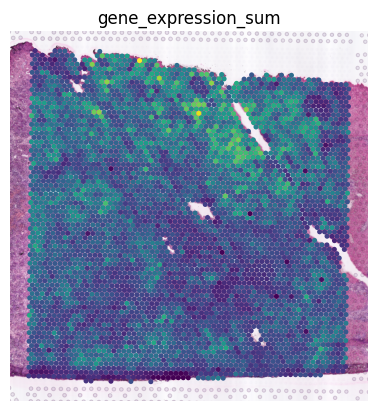

In [3]:
adata.obs['gene_expression_sum'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else adata.X.sum(axis=1)
sc.pl.spatial(adata,color = ['gene_expression_sum'],frameon = False,colorbar_loc=None,groups=[3],spot_size=200)

In [4]:
model = stGACN.stGACN(adata,k_cutoff=4,device=device,neighborhood=4,model_select = 'KNN',epochs = 600)
# train model
adata = model.train()

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Graph_1 Construction
The graph contains 13548 edges, 4516 cells.
3.0000 neighbors per cell on average.
Graph constructed!
Graph_2 Construction
The graph contains 18064 edges, 4516 cells.
4.0000 neighbors per cell on average.
Begin to train ST data...


  0%|          | 0/600 [00:00<?, ?it/s]

Overall loss : tensor(45.3139, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 103/600 [00:05<00:22, 22.23it/s]

Overall loss : tensor(13.7068, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 205/600 [00:09<00:17, 22.26it/s]

Overall loss : tensor(12.0231, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 304/600 [00:14<00:13, 22.41it/s]

Overall loss : tensor(10.9532, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 403/600 [00:18<00:08, 22.10it/s]

Overall loss : tensor(10.5521, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 505/600 [00:23<00:04, 22.12it/s]

Overall loss : tensor(10.4953, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 600/600 [00:27<00:00, 21.95it/s]


Optimization finished for ST data!


In [5]:
n_clusters = 16
radius = 30
tool = 'leiden' # mclust, leiden, and louvain

# clustering
from stGACN.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=False) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=1.8, increment=0.01, refinement=False)

Searching resolution...
resolution=1.7899999999999991, cluster number=18
resolution=1.7799999999999994, cluster number=18
resolution=1.7699999999999994, cluster number=18
resolution=1.7599999999999993, cluster number=18
resolution=1.7499999999999993, cluster number=17
resolution=1.7399999999999993, cluster number=19
resolution=1.7299999999999993, cluster number=18
resolution=1.7199999999999993, cluster number=18
resolution=1.7099999999999993, cluster number=18
resolution=1.6999999999999993, cluster number=16


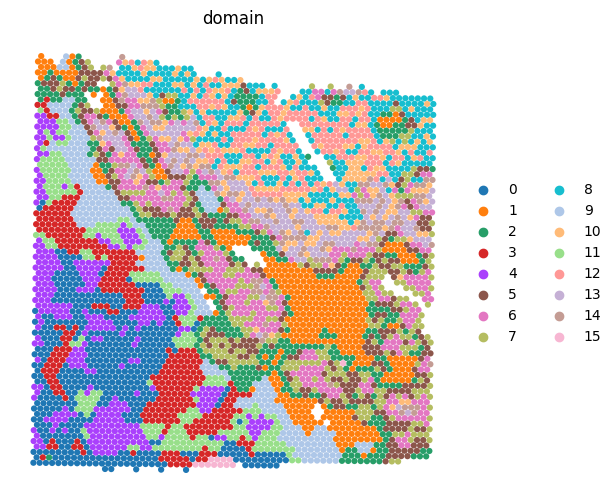

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
sc.pl.spatial(adata,basis='spatial',color = 'domain',frameon = False,colorbar_loc=None,spot_size=200,alpha_img=0)

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


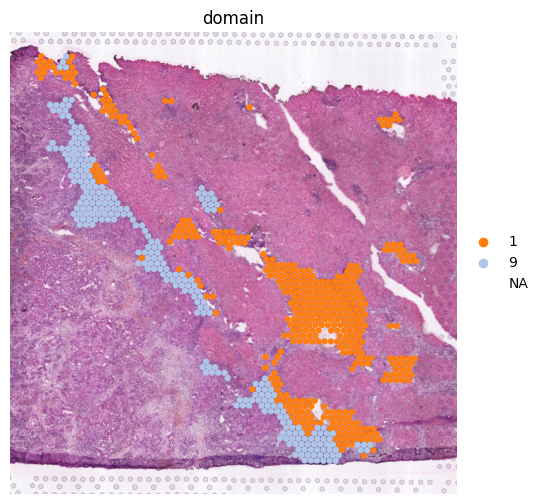

In [10]:
sc.pl.spatial(adata,basis='spatial',color = 'domain',groups=['1','9'],frameon = False,colorbar_loc=None,spot_size=200)

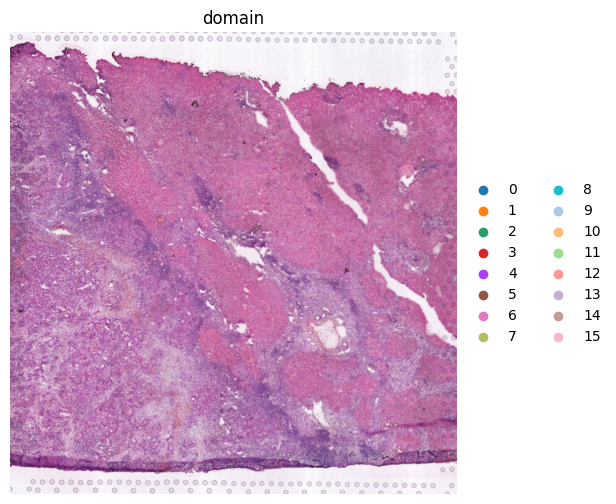

In [12]:
sc.pl.spatial(adata,basis='spatial',color = 'domain',frameon = False,colorbar_loc=None,spot_size=0)

In [8]:
# adata.write_h5ad('BLCA_stGACN_126.h5ad')